# Tracking Portfolio with Cardinality Constraints

**Author:** Fatima Kasenally
**Date:** Sept 2025

---
**Abstract:**  
This project implements a cardinality-constrained index tracking strategy. Using historical stock prices, we construct sparse portfolios that aim to track the S&P benchmark index. Portfolios are optimized over rolling two-year windows with rebalancing, and results are compared to a the S&P index benchmark and to a fixed-weight strategy. The notebook shows the data processing, optimization, and backtesting workflow.

## Data Processing
We load the raw stock and index price data, clean missing values, and compute daily returns.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
DATA_PATH = 'Prices.csv'
rawData = pd.read_csv(DATA_PATH)
print('Raw data shape:', rawData.shape)

# Extract index series separately
SNPIndex = pd.read_csv(DATA_PATH, usecols=['Date', 'ES Index-A1-UnAdj on CME_USD (USD)'])

# Extract only stocks
StockValues = rawData.drop(columns=['ES Index-A1-UnAdj on CME_USD (USD)'])

# Fill initial NaNs in stock time series
for col in StockValues.select_dtypes(include='number').columns:
    first_val = StockValues[col].dropna().iloc[0]
    StockValues[col] = StockValues[col].fillna(first_val)

# Compute daily returns
StockPR = StockValues.drop(columns=['Date']).pct_change().iloc[1:]
SNP_PR = SNPIndex.drop(columns=['Date']).pct_change().dropna()

# Dates
Dates = pd.read_csv(DATA_PATH, usecols=['Date']).to_numpy().flatten()[1:]
Dates = pd.to_datetime(Dates, dayfirst=True)

# Cumulative returns (used in optimization)
R = StockPR.cumsum().to_numpy()
r = SNP_PR.cumsum().to_numpy().flatten()

del rawData, SNPIndex, StockValues

print('Prepared returns shapes: R:', R.shape, 'r:', r.shape)

Raw data shape: (3848, 733)
Prepared returns shapes: R: (3847, 731) r: (3847,)


## Optimization Function
We define the function that constructs sparse tracking portfolios by iteratively removing small weights until the cardinality constraint is satisfied. This method is developped in the file 'In_Sample_SNP_Tracker.py', which was the first part of this project.

In [24]:
import osqp
from scipy import sparse

def cardinality_tracking(P, q, A, l, u, max_cardinality, counter=True):
    n = q.shape[0]
    Trading_Stocks = n
    w_mask = np.ones(n)
    weightings = []
    
    while Trading_Stocks > max_cardinality:
        u_iter = np.hstack([1., np.ones(n) * w_mask])
        Trading_Stocks = int(sum(w_mask))
        
        prob = osqp.OSQP()
        prob.setup(P, q, A, l, u_iter, verbose=False, eps_abs=1e-5, eps_rel=1e-5)
        res = prob.solve()
        w_opt_i = res.x
        weightings.append(w_opt_i)
        
        # Remove smallest half of active weights
        median_w = np.median(w_opt_i[abs(w_opt_i) > 1e-5]) if np.any(abs(w_opt_i) > 1e-5) else 0.
        w_mask = np.ones(n) * (w_opt_i > median_w)
        
        if counter:
            print(f"Trading stocks remaining: {Trading_Stocks}")
    
    return weightings[-1], weightings, Trading_Stocks

## Windowed Portfolio Construction
We split the dataset into two-year windows, optimize tracker portfolios in-sample, and store the resulting weightings.

In [25]:
years = Dates.year
unique_years, first_pos = np.unique(years, return_index=True)

window_weightings = []
window_portfolio_size = []

for i in range(2, len(unique_years)):
    start_idx = first_pos[i-2]
    end_idx = first_pos[i]
    R_window = R[start_idx:end_idx, :]
    r_window = r[start_idx:end_idx]
    
    P_window = 2 * (R_window.T @ R_window)
    q_window = -2 * (R_window.T @ r_window)
    P_sparse_window = sparse.csc_matrix(P_window)
    n_window = R_window.shape[1]
    
    A_window = sparse.bmat([[np.ones((1, n_window)), None],
                            [sparse.eye(n_window), None]], format='csc')
    l_window = np.hstack([1., np.zeros(n_window)])
    u_window = np.hstack([1., np.ones(n_window)])
    
    max_card = 50
    w_opt_final, all_iterations, portfolio_size = cardinality_tracking(P_sparse_window, q_window, 
                                                                       A_window, l_window, u_window, 
                                                                       max_card, counter=False)
    window_weightings.append(w_opt_final)
    window_portfolio_size.append(portfolio_size)

print('Number of windows optimized:', len(window_weightings))

Number of windows optimized: 14


## Out-of-Sample Projection
We project each window’s optimal portfolio forward by one year and compare the fully projected series against the benchmark. The performance of the SNP 500 index from 2012-2025 is shown in blue. In orange, we see the tracking portfolio, with weights rebalanced every year. The green trendline shows the performance of the portfolio optimised for the years 2010-2012 projected forwards over the next 13 years. 

The two smaller `Trackin Error' plots, visualise the difference between the index and portfolio's performance. The mean square error (MSE) of each in then reported.

MSE (annual rebalancing): 0.00198569
MSE (fixed weighting): 0.0141849


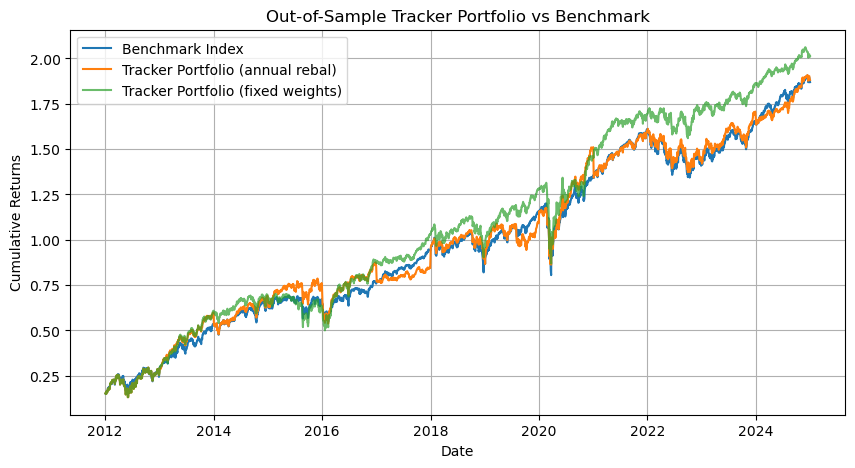

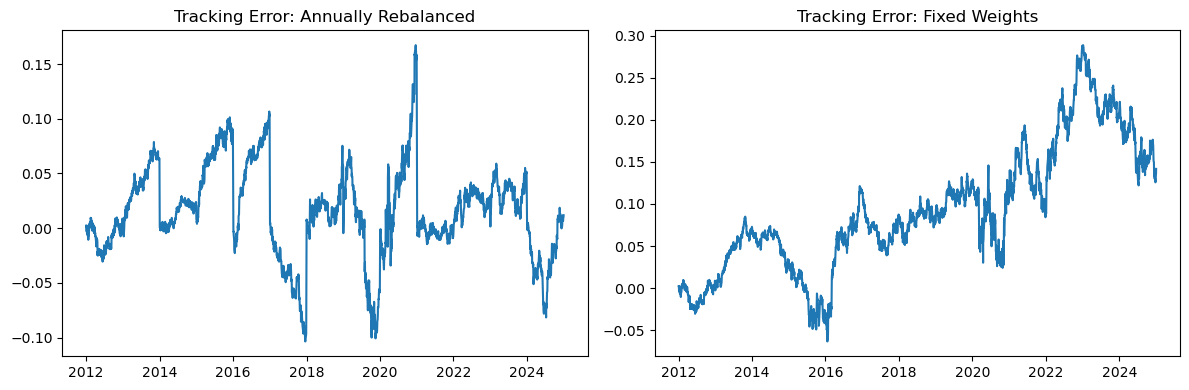

In [32]:
projected_portfolio = []
for i in range(2, len(unique_years)-1):
    start_idx = first_pos[i]
    end_idx = first_pos[i+1]
    R_projected = R[start_idx:end_idx, :]
    projected_portfolio.append(R_projected @ window_weightings[i-2])

projected_portfolio = np.concatenate(projected_portfolio)
start_idx = first_pos[2]
end_idx = first_pos[-1]

# Fixed-weight strategy (first window weights only)
projected_portfolio_win1 = R[start_idx:end_idx, :] @ window_weightings[0]

# Compute mean squared errors
mse_rebal = np.mean((projected_portfolio - r[start_idx:end_idx])**2)
mse_fixed = np.mean((projected_portfolio_win1 - r[start_idx:end_idx])**2)
print(f"MSE (annual rebalancing): {mse_rebal:.6g}")
print(f"MSE (fixed weighting): {mse_fixed:.6g}")

# Plot cumulative returns
plt.figure(figsize=(10,5))
plt.plot(Dates[start_idx:end_idx], r[start_idx:end_idx], label='Benchmark Index')
plt.plot(Dates[start_idx:end_idx], projected_portfolio, label='Tracker Portfolio (annual rebal)')
plt.plot(Dates[start_idx:end_idx], projected_portfolio_win1, label='Tracker Portfolio (fixed weights)', alpha=0.7)
plt.xlabel('Date'); plt.ylabel('Cumulative Returns')
plt.title('Out-of-Sample Tracker Portfolio vs Benchmark')
plt.legend(); plt.grid(True); plt.show()

# Tracking error plots
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(Dates[start_idx:end_idx], projected_portfolio - r[start_idx:end_idx])
axes[0].set_title('Tracking Error: Annually Rebalanced')
axes[1].plot(Dates[start_idx:end_idx], projected_portfolio_win1 - r[start_idx:end_idx])
axes[1].set_title('Tracking Error: Fixed Weights')
plt.tight_layout(); plt.show()

## Analysis & Discussion

From the figures above, we see the rebalanced portflio more closely follows the SNP index (as expected). The fixed weight portfolio outperforms the SNP index over the long term, but fails its objective to mimic the SNP performance. The more time that passes after rebalancing the weights, the worse the tracking error gets. Analysts can assess the decline in performance to inform decisions on rebalancing frequency. 

The more frequently the portfolio is rebalanced, the higher the trading costs incurred. 

In [34]:
weights_array = np.array(window_weightings)
abs_weight_changes = np.abs(weights_array[1:] - weights_array[:-1])
yearly_trading_costs = np.sum(abs_weight_changes, axis=1) * 4

print(f"Average yearly trading cost: {np.mean(yearly_trading_costs):.6g} Basis Points")

Average yearly trading cost: 6.73001 Basis Points


# Portfolio Cardinality

The following figure shows the cardinality of the portfolio (i.e. the number of stocks being activley traded). We see our portfolio construction algorithm successfully reduces the portfolio from 731 available stocks, to below the cardinality threshold, which here is set to 50 stocks. In this case the full portfolio had a MSE of 0.002 BP. The year indicates the end of the 2-year window for which the weights were optimised for teacking.  

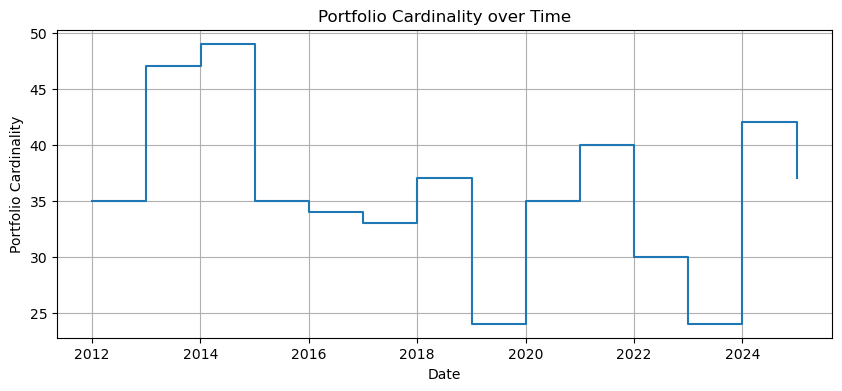

In [29]:
# Portfolio cardinality over time
plt.figure(figsize=(10,4))
plt.step(Dates[first_pos[2:]], window_portfolio_size, where='post')
plt.xlabel('Date'); plt.ylabel('Portfolio Cardinality')
plt.title('Portfolio Cardinality over Time')
plt.grid(True); plt.show()

## Further Enhancements

To reduce trading costs, we can adapt our original objective function to include a penalty term, which restricts the volume traded while rebalancing. This is Lasso regression, with the objective function: 
$$ \underset{w}{ArgMin} \left\{ ||Rw_T - r||^2_2 + \lambda(w_{T-1} - w_{T})^2 \right\}$$

Where $R$ is our data matrix of stocks and cumulative returns, $r$ is the cumulative returns of the index we are tracking, and $w_T$ is a weighting vector that tells us the optimal weighting/combination of stocks to include in our tracking portfolio. $w_{T-1}$ is the optimal weighting produced by the previous time window, and $\lambda$ is the penalty parameter that controls how strictly we restrict changes to the weighting allocations between rebalances. 

This is still a quadratic optimisation problem, that can be solved by the OSQP package. We simply construct the problem as: 
$$ w_T\left[ R^TR + 2\lambda I \right ] w_T - \left[ 2r^TR + 2\lambda w_{T-1}^T \right ] w_{T}  = \frac{1}{2} w_T Q w_T - pw_T$$

With the constraints unchanged. We then simply minimize the expression with respect to $w_T$

